# Brightfield Segmentation: Mask R-CNN

<img src="http://reconstrue.com/assets/images/reconstrue_combo_mark.svg" width="266px"/>

- brightfield_on_colab [Issue #183: Mask R-CNN](https://github.com/reconstrue/brightfield_on_colab/issues/183)
- Forked from [mask_rcnn_demo.ipynb](https://colab.research.google.com/github/tensorflow/tpu/blob/master/models/official/mask_rcnn/mask_rcnn_demo.ipynb) on 2020-04-02
- This uses TF1.x APIs

This Colab notebook enables you to use a Mask R-CNN model that was trained on Cloud TPU to perform instance segmentation on a random Minimum Intensity Projection image from the Allen Institute. The resulting predictions are overlayed on the sample image as boxes, instance masks, and labels. In this example, a very large pale yellow overlay is used. 

This code "naive" in that this uses a completely pre-trained model which knows nothing about brain tissue imagery. Basically, this experiment just shows that some custom training will be required. 

Hopefully transfer learning can be leveraged to reduce the training load. But in the end, a bottom-up bespoke code solution will probably be required, something like a custom model starting with single-channel images containing lots of images of biocytin-stained neurons.

### About Mask R-CNN
The Mask R-CNN model addresses one of the most difficult computer vision challenges: image segmentation. Image segmentation is the task of detecting and distinguishing multiple objects within a single image. In particular, Mask R-CNN performs "instance segmentation," which means that different instances of the same type of object in the input image, for example, car, should be assigned distinct labels.

## Legal

This code is [licensed by Reconstrue under the Apache 2.0 License](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/blob/master/LICENSE).


In [0]:
# Copyright 2019-2020 Reconstrue Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Set-up


### Set runtime to TPU
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   2. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

### Download the source code
Download the source code of the Mask R-CNN model.

In [2]:
!git clone https://github.com/tensorflow/tpu/

fatal: destination path 'tpu' already exists and is not an empty directory.


### Import libraries

In [3]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

TensorFlow 1.x selected.


### Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [0]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Crunch data

### Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

--2020-04-02 19:25:50--  http://api.brain-map.org/api/v2/section_image_download/323637357
Resolving api.brain-map.org (api.brain-map.org)... 63.237.233.29
Connecting to api.brain-map.org (api.brain-map.org)|63.237.233.29|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: //api.brain-map.org/cgi-bin/imageservice?mime=1&path=/external/mousecelltypes/prod146/specimen_313862022/min_xy_313862022.aff&left=0&top=0&width=5762&height=7570&downsample=0 [following]
--2020-04-02 19:25:50--  http://api.brain-map.org/cgi-bin/imageservice?mime=1&path=/external/mousecelltypes/prod146/specimen_313862022/min_xy_313862022.aff&left=0&top=0&width=5762&height=7570&downsample=0
Reusing existing connection to api.brain-map.org:80.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test.jpg’

test.jpg                [       <=>          ]   1.73M  1.29MB/s    in 1.3s    

2020-04-02 19:25:52 (1.29 MB/s) - ‘test.jpg’ saved [1812191]



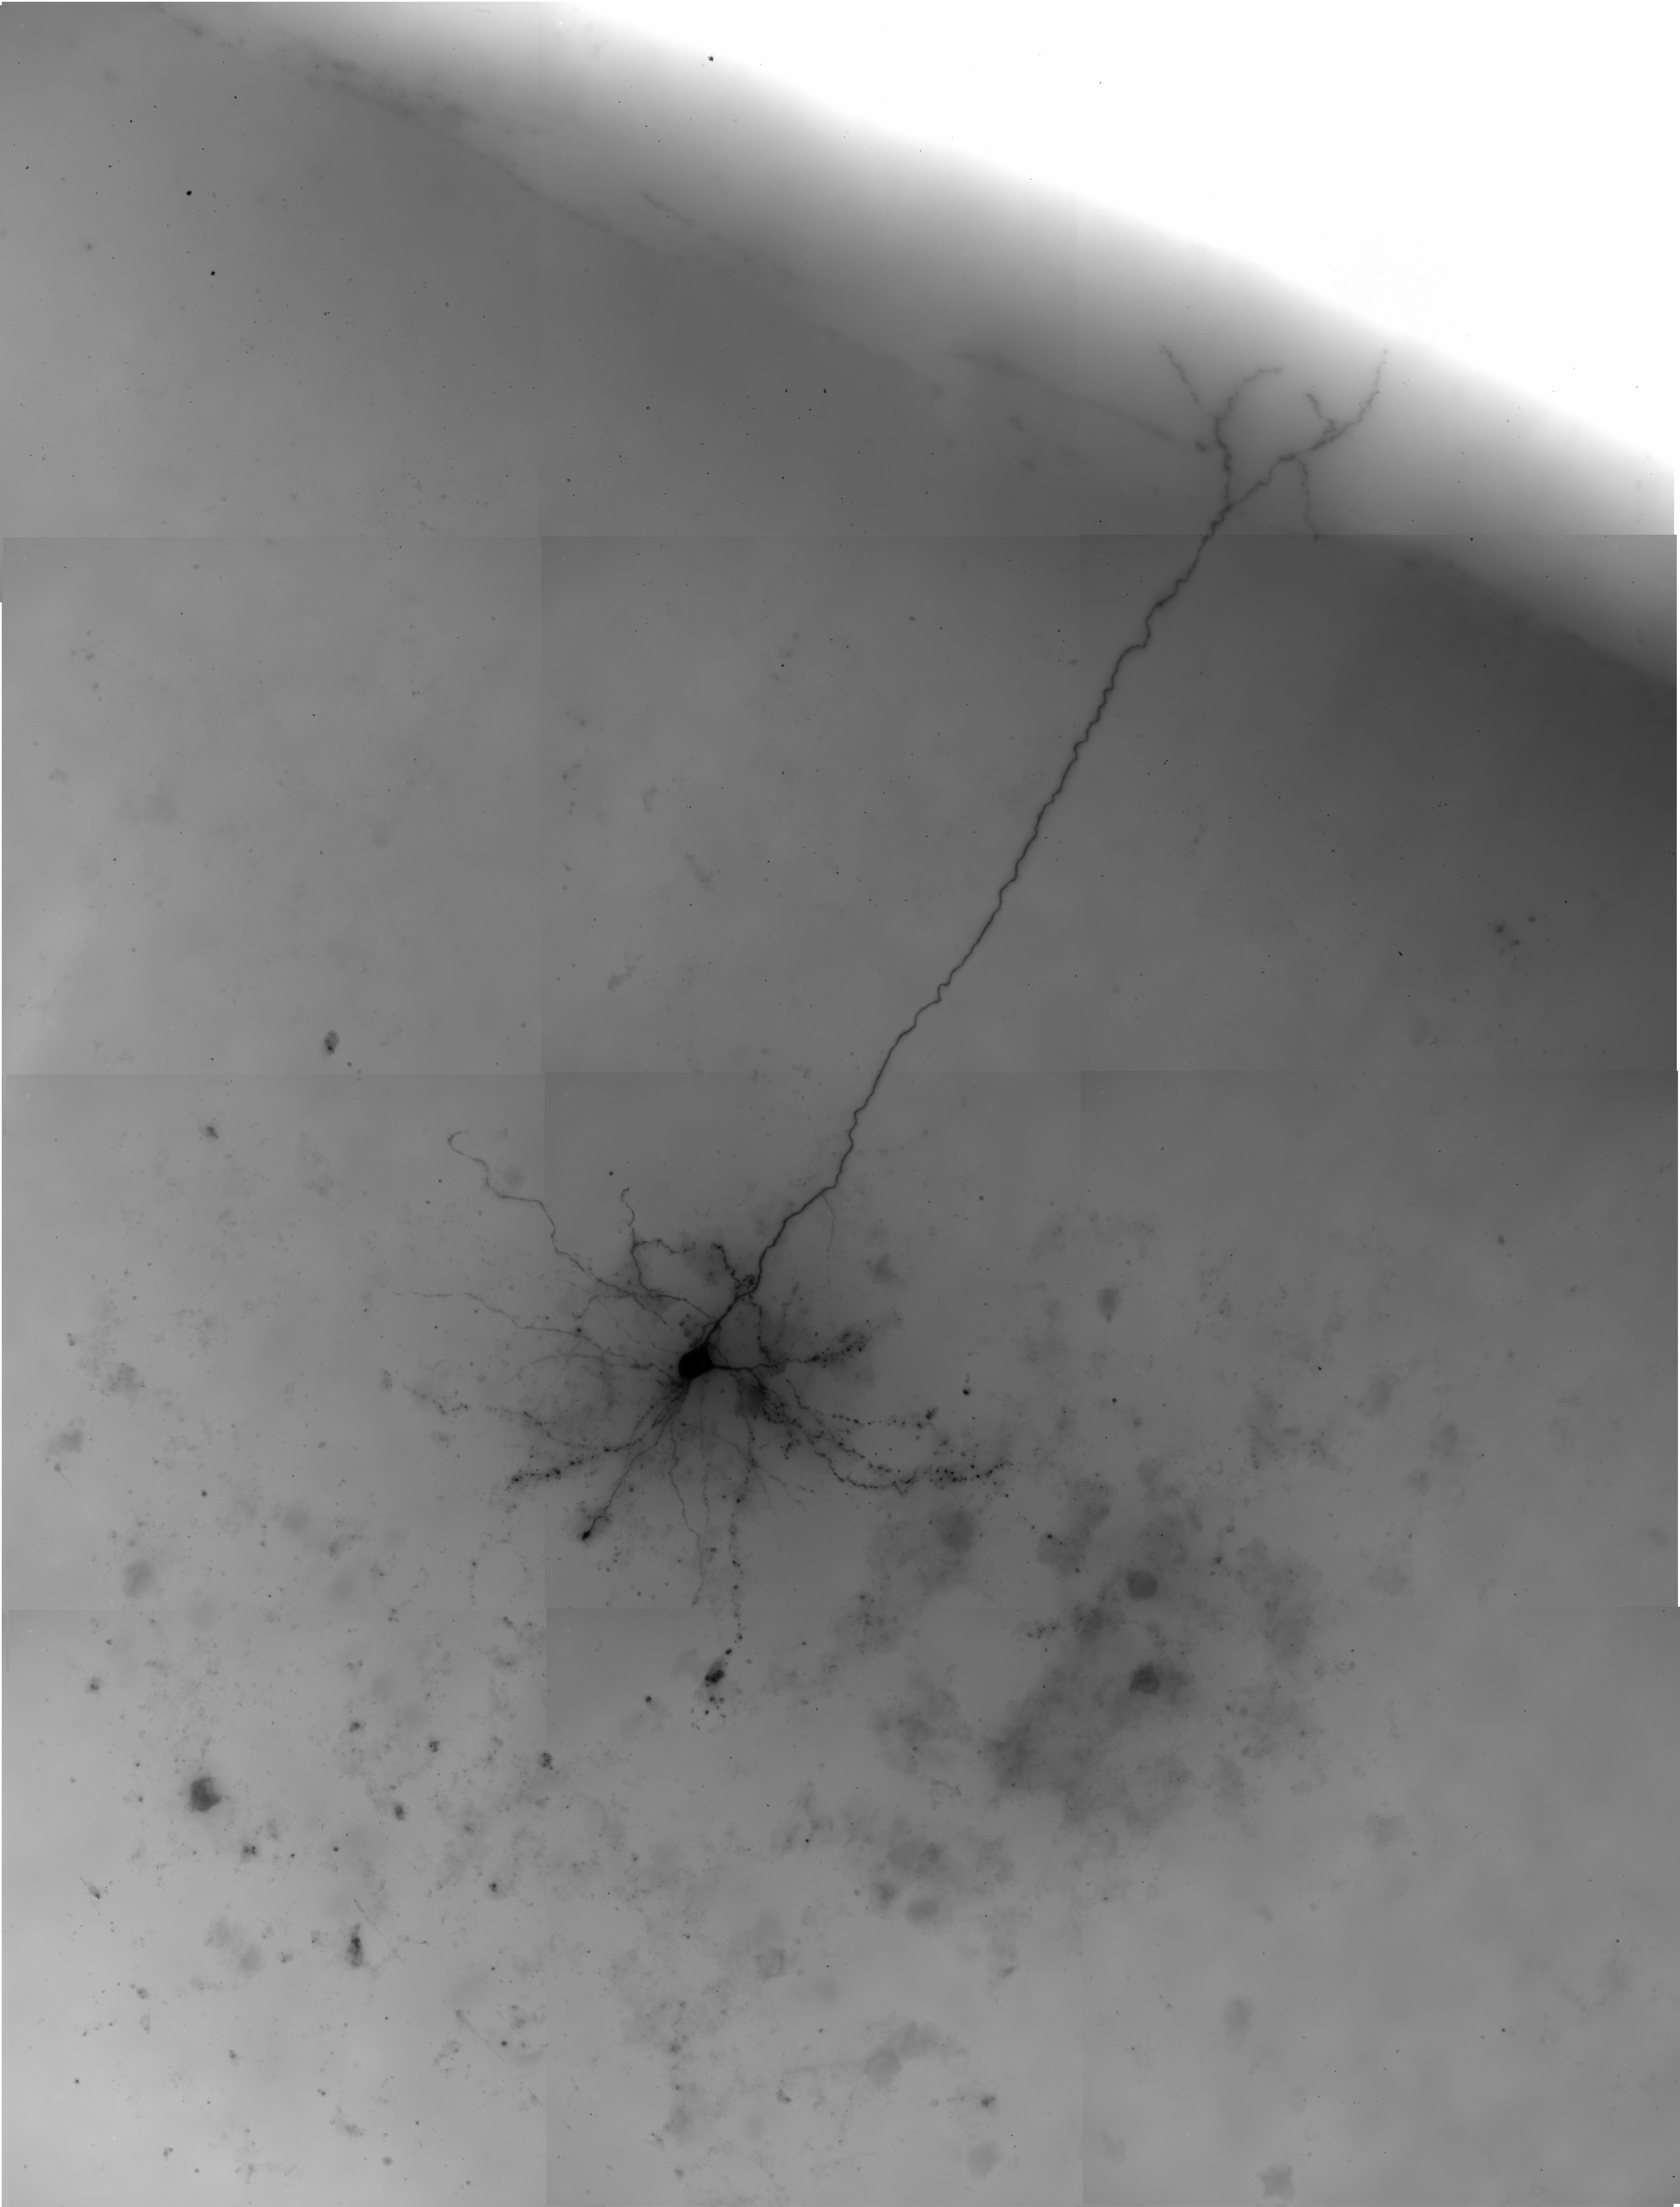

In [10]:
#original_demo_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg"
#!wget {original_demo_url} -O test.jpg

minip_url = "http://api.brain-map.org/api/v2/section_image_download/323637357"
!wget {minip_url} -O test.jpg
image_path = 'test.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

### Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [11]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.75.93.154:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 5101208059163666300),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16755394166601593142),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4444377437700707417),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12934645308663138209),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12862732984352893044),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3210277342988546860),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12116052177313959477),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 8623948378476984272),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 550315971370

## Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [12]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


### Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [0]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [15]:
print(detection_classes)

[ 5  5 81]


### Visualize the detection results
Time to check out the result!

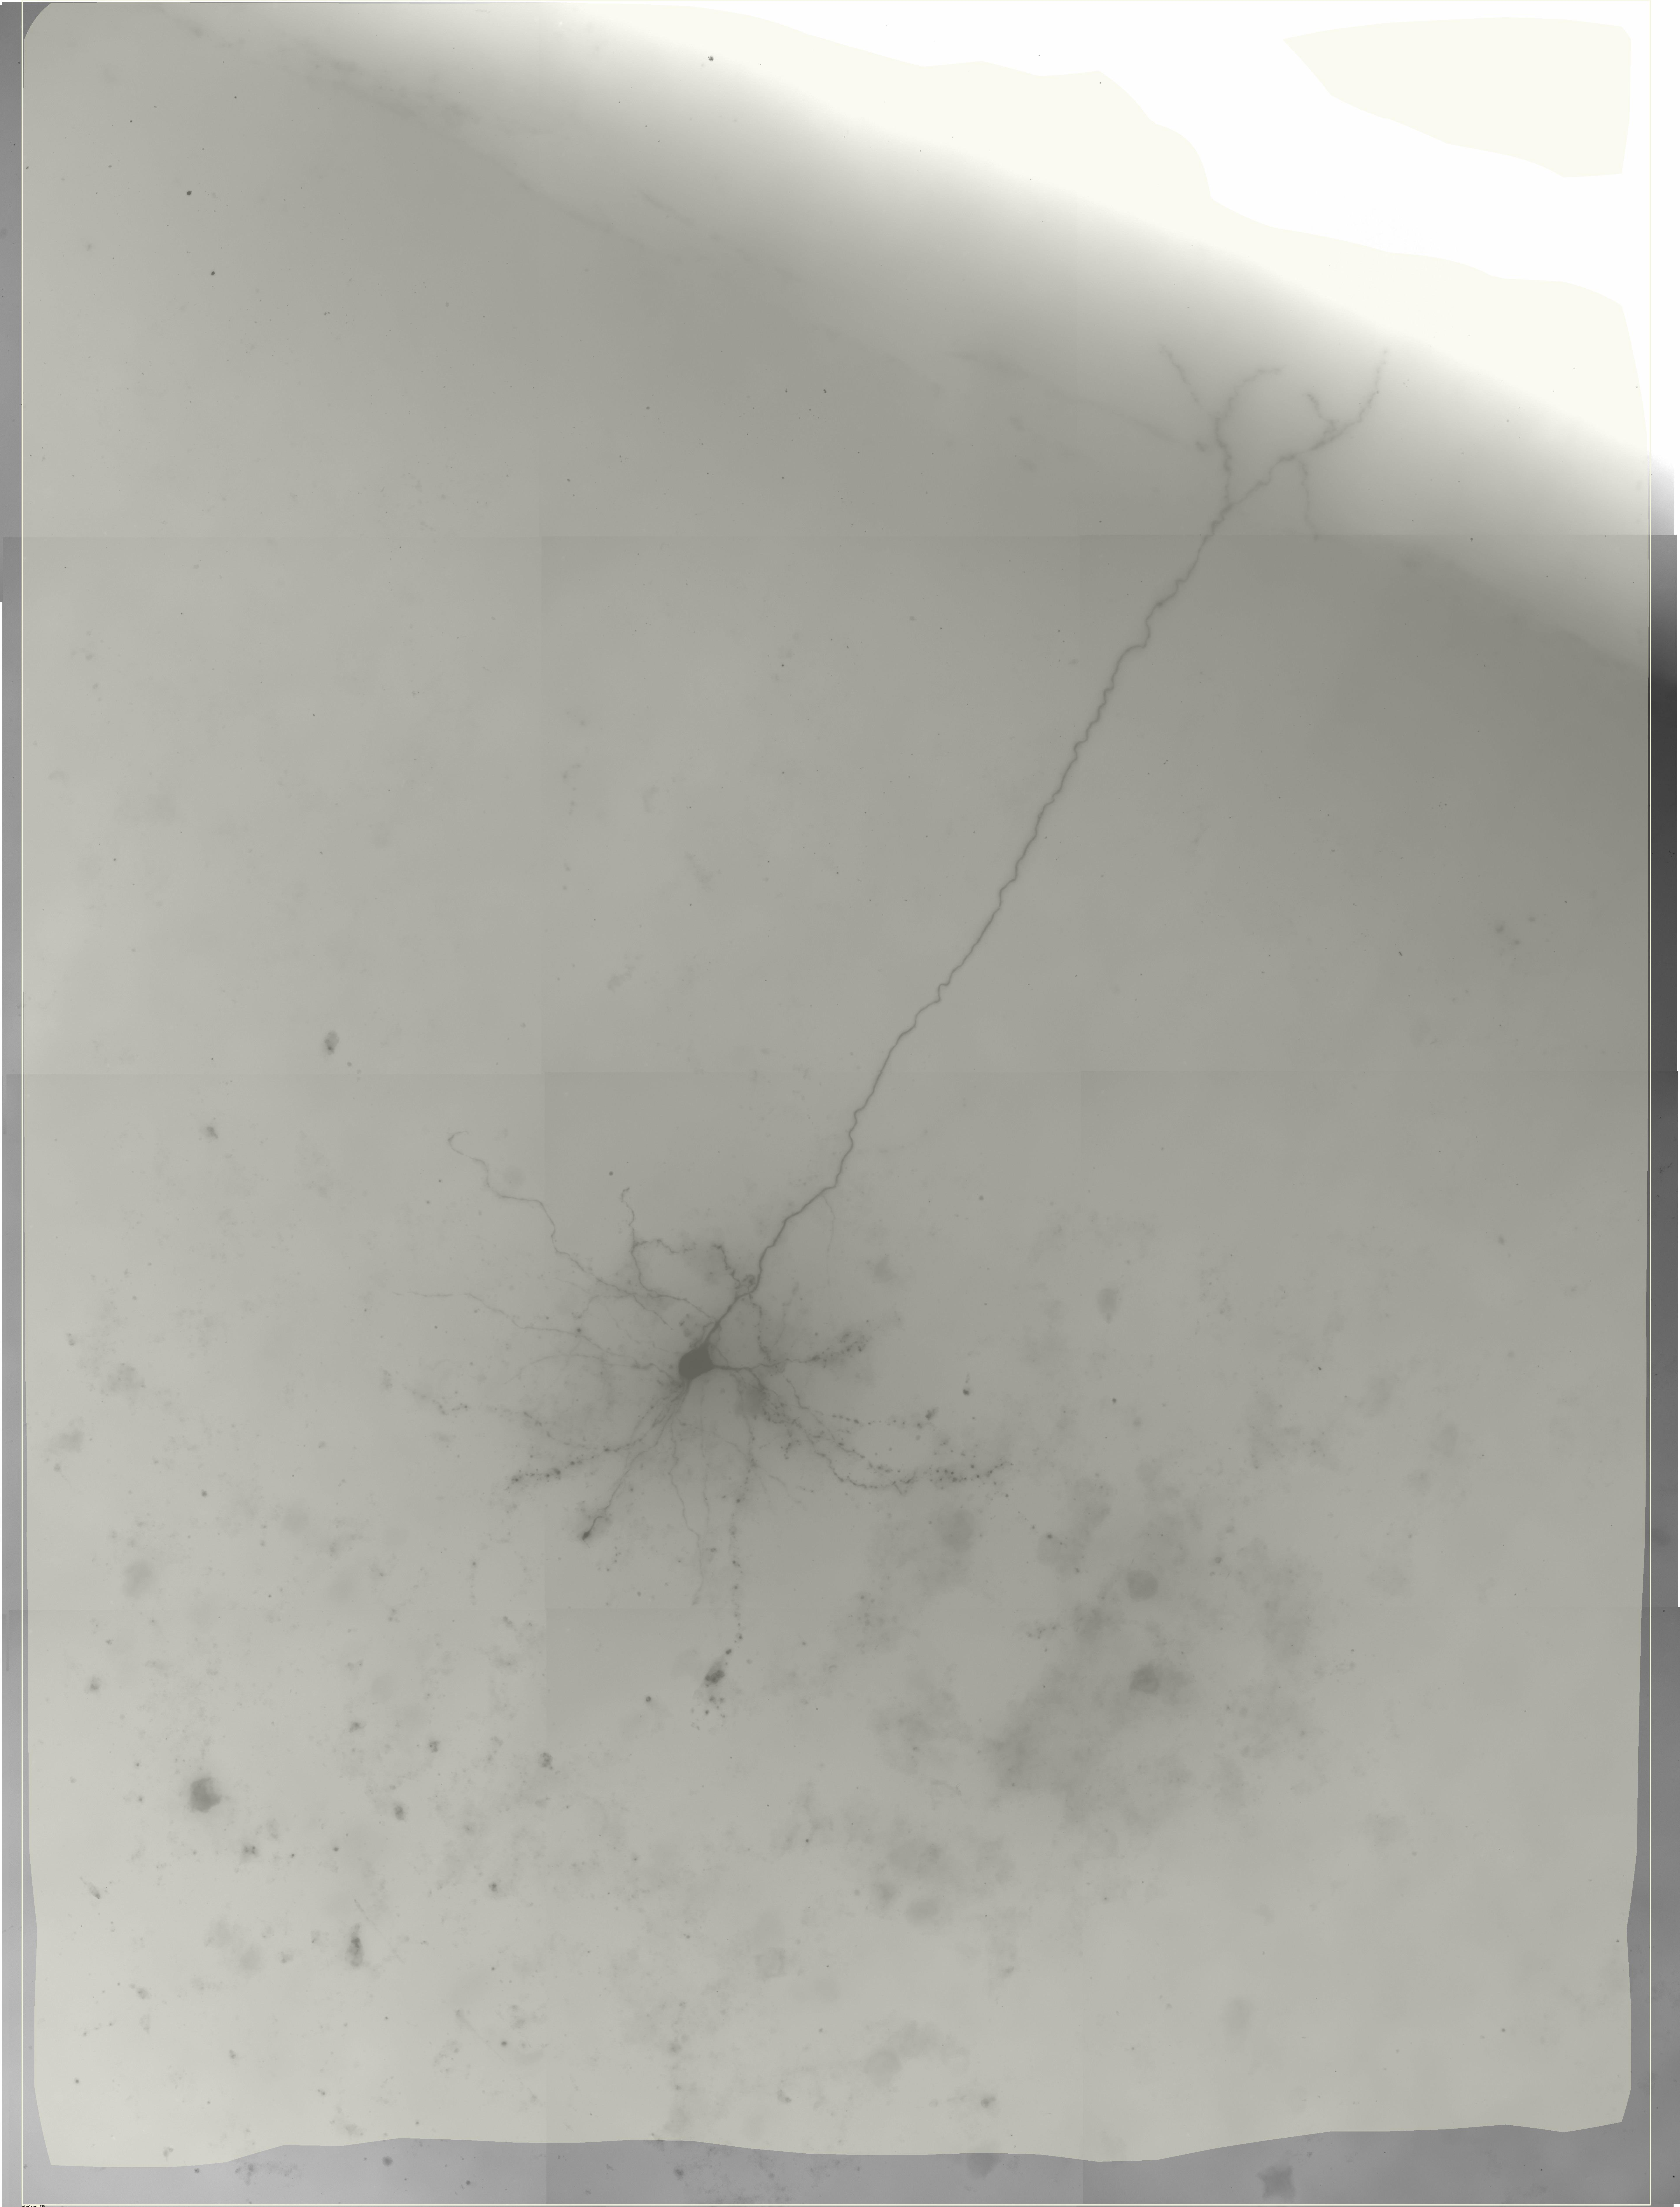

In [14]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.1    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

## Download labeled output image

In [0]:
from google.colab import files

files.download('test_results.jpg')